# Benchmarking VASP / VaspInteractive + ALMLP
Use `cluster_mlp.fillPoll` to generate random metal cluster size.

For each cluster, compare the following relaxation results:
- `vasp+bfgs`: 
    - Pure VASP single point calculator (mimicked by setting `nsw=0` in `VaspInteractive`)
    - Use `ase.optimize.bfgs` as direct optimizer
- `vasp+al`:
    - Pure VASP single point
    - Flare potential + bfgs minimatch
- `vpi_bfgs`: 
    - `VaspInteractive` calculator
    - Use `ase.optimize.bfgs` as direct optimizer
- `vpi+al`:
    - `VaspInteractive` calculator
    - Flare potential + bfgs minimatch
    
Following quantities are compared:
- Total wall time
- Total parent (DFT) calls
- Total electronic steps

Note, this test requires `ulissigroup/kubeflow_vasp:clusterga` image and a working worker pod config yaml file.
To enable cache sharing on all worker pods, volume mounting should be set inside the yaml file.

In [5]:
%cd /home/jovyan/data/vasp-interactive-test/examples/

/home/jovyan/data/vasp-interactive-test/examples


In [6]:
import joblib
from joblib import Memory

In [7]:
from ex10_mlp_online import run_opt, gen_cluster
from dask_kubernetes import KubeCluster
from dask.distributed import Client
import dask.bag as bag

In [8]:
cluster = KubeCluster("worker-cpu-spec-large.yml")
client = Client(cluster)
cluster.adapt(maximum=10)

Creating scheduler pod on cluster. This may take some time.


distributed.deploy.adaptive - INFO - Adaptive scaling started: minimum=0 maximum=10


### Use `joblib.memory` to cache partial results
We use `joblib.memory` to lazy evaluate execution of code. For each function call, an additional parameter `i` is provided for generating a unique structure.

You can test this by running `gen_cluster_iter("Cu", 10, 0)` multiple times, they should give you identical structures

In [54]:
from pathlib import Path
curdir = Path(".").resolve()
bench_root = curdir / "mlp_cluster_benchmark" / "cache"

In [55]:
memory = Memory(bench_root)

In [56]:
@memory.cache
def gen_cluster_iter(metal, n, i):
    cluster = gen_cluster(metal, n)
    return cluster

In [58]:
t1 = gen_cluster_iter("Cu", 10, 0)
t2 = gen_cluster_iter("Cu", 10, 0)
t1 == t2

True

In [59]:
@memory.cache
def run_opt_cached(structure, **params):
    """Cached version of results"""
    return run_opt(structure, **params)

In [60]:
def run_benchmark_cluster(metal, n, i):
    """Run 4x cycles"""
    results = dict(metal=metal, n=n)
    initial_structure = gen_cluster_iter(metal, n, i)
    parameters = [dict(vasp="Vasp", use_al=False, store_wf=True),
                 dict(vasp="Vasp", use_al=True, store_wf=True),
                 dict(vasp="VaspInteractive", use_al=True, store_wf=True),
                 dict(vasp="VaspInteractive", use_al=False, store_wf=True)]
    keys = ["vasp+bfgs", "vasp+al", "vpi+bfgs", "vpi+al"]
    param_seq = [param for param in parameters]
    for key, param in zip(keys, parameters):
        try:
            t, steps, fin, _ = run_opt_cached(initial_structure, **param)
            results[key] = dict(t=t, steps=steps, final_image=fin)
        except RuntimeError:
            results[key] = None
    return results

In [61]:
import itertools
cluster_size = range(3, 25, 3)
sample_indices = range(10)
seq = list(itertools.product(["Cu"], cluster_size, sample_indices))

In [62]:
jobs = bag.from_sequence(seq).map(lambda v: run_benchmark_cluster(*v))

In [63]:
jobs

dask.bag<lambda, npartitions=80>

In [64]:
job_done = jobs.compute()

distributed.deploy.adaptive - INFO - Retiring workers [2, 3, 4, 5, 6, 7]
distributed.deploy.adaptive - INFO - Retiring workers [0]
distributed.deploy.adaptive - INFO - Retiring workers [1]


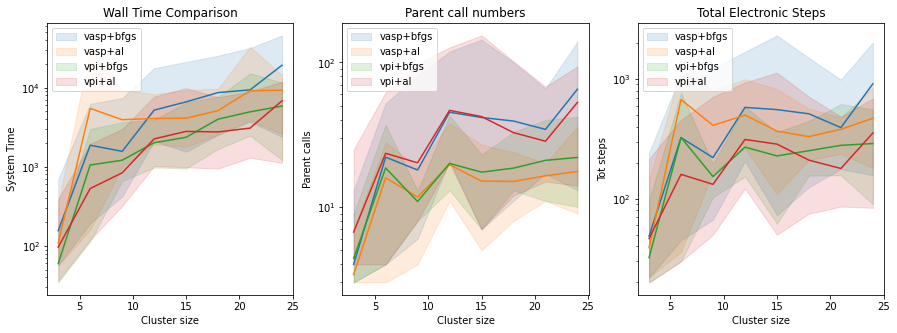

In [65]:
import matplotlib.pyplot as plt
import numpy as np



time = {"vasp+bfgs": {}, "vasp+al": {}, "vpi+bfgs": {}, "vpi+al": {}}
tot_steps = {"vasp+bfgs": {}, "vasp+al": {}, "vpi+bfgs": {}, "vpi+al": {}}
parent_calls = {"vasp+bfgs": {}, "vasp+al": {}, "vpi+bfgs": {}, "vpi+al": {}}

for entry in job_done:
    n = entry["n"]
    for key in time.keys():
        old_arr = time[key].get(n, [])
        if entry[key] is not None:
            old_arr.append(entry[key]["t"])
        else:
            old_arr.append(np.nan)
        time[key][n] = old_arr
        
for entry in job_done:
    n = entry["n"]
    for key in parent_calls.keys():
        old_arr = parent_calls[key].get(n, [])
        if entry[key] is not None:
            old_arr.append(len(entry[key]["steps"]))
        else:
            old_arr.append(np.nan)
        parent_calls[key][n] = old_arr
        
for entry in job_done:
    n = entry["n"]
    for key in tot_steps.keys():
        old_arr = tot_steps[key].get(n, [])
        if entry[key] is not None:
            old_arr.append(sum(entry[key]["steps"]))
        else:
            old_arr.append(np.nan)
        tot_steps[key][n] = old_arr

plt.figure(figsize=(15, 5))

plt.subplot(131)

for key in time.keys():
    size = []
    raw_time = []
    for k, v in time[key].items():
        size.append(k)
        raw_time.append(v)
    size = np.array(size)
    raw_time = np.array(raw_time)
    l, *_ = plt.plot(size, np.nanmean(raw_time, axis=1),)
    plt.fill_between(x=size, y1=np.nanmin(raw_time, axis=1),
                     y2=np.nanmax(raw_time, axis=1), label=key, color=l.get_c(), alpha=0.15)

plt.title("Wall Time Comparison")
plt.ylabel("System Time")
plt.xlabel("Cluster size")
plt.yscale("log")
plt.legend()

plt.subplot(132)

for key in parent_calls.keys():
    size = []
    raw_pcalls = []
    for k, v in parent_calls[key].items():
        size.append(k)
        raw_pcalls.append(v)
    size = np.array(size)
    raw_pcalls = np.array(raw_pcalls)
    l, *_ = plt.plot(size, np.nanmean(raw_pcalls, axis=1))
    plt.fill_between(size, np.nanmin(raw_pcalls, axis=1), 
                     np.nanmax(raw_pcalls, axis=1), label=key, color=l.get_c(), alpha=0.15)

#     plt.errorbar(x=size, y=np.nanmean(raw_pcalls, axis=1), 
#                  yerr=np.vstack([np.nanmean(raw_pcalls, axis=1) - np.nanmin(raw_pcalls, axis=1),
#                                  np.nanmax(raw_pcalls, axis=1) - np.nanmean(raw_pcalls, axis=1)]), label=key)

plt.title("Parent call numbers")
plt.ylabel("Parent calls")
plt.yscale("log")
plt.xlabel("Cluster size")
plt.legend()

plt.subplot(133)

for key in tot_steps.keys():
    size = []
    raw_steps = []
    for k, v in tot_steps[key].items():
        size.append(k)
        raw_steps.append(v)
    size = np.array(size)
    raw_steps = np.array(raw_steps)
    l, *_ = plt.plot(size, np.nanmean(raw_steps, axis=1))
    plt.fill_between(size, np.nanmin(raw_steps, axis=1), np.nanmax(raw_steps, axis=1), label=key,
            color=l.get_c(), alpha=0.15)
#     plt.errorbar(x=size, y=np.nanmean(raw_steps, axis=1), 
#                  yerr=np.vstack([np.nanmean(raw_steps, axis=1) - np.nanmin(raw_steps, axis=1),
#                                  np.nanmax(raw_steps, axis=1) - np.nanmean(raw_steps, axis=1)]), label=key)

plt.title("Total Electronic Steps")
plt.ylabel("Tot steps")
plt.xlabel("Cluster size")
plt.yscale("log")
plt.legend()
plt.show()

In addition, we can compare the speed-up for "vasp+al", "vpi+bfgs" and "vpi+al" methods vs "vasp+bfgs", for the same structure

Due to display issue, only the average curve is shown

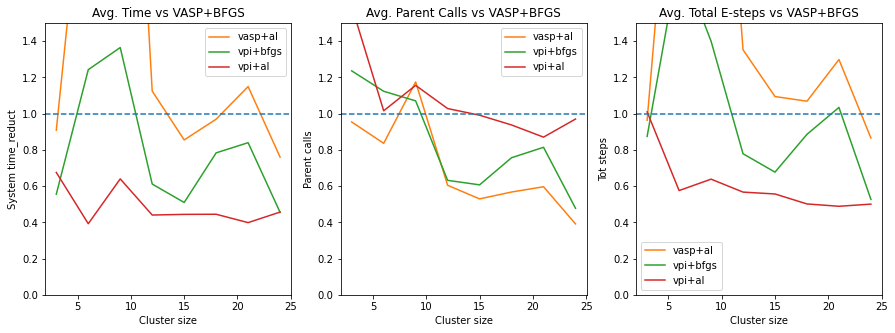

In [68]:
import matplotlib.pyplot as plt
import numpy as np



time_reduct = {"vasp+al": {}, "vpi+bfgs": {}, "vpi+al": {}}
steps_reduct = {"vasp+al": {}, "vpi+bfgs": {}, "vpi+al": {}}
pcall_reduct = {"vasp+al": {}, "vpi+bfgs": {}, "vpi+al": {}}

for entry in job_done:
    n = entry["n"]
    try:
        t_ref = entry["vasp+bfgs"]["t"]
    except KeyError:
        for key in time_reduct.keys():
            time_reduct[key][n] = np.nan
        continue
    
    for key in time_reduct.keys():
        old_arr = time_reduct[key].get(n, [])
        if entry[key] is not None:
            old_arr.append(entry[key]["t"] / t_ref)
        else:
            old_arr.append(np.nan)
        time_reduct[key][n] = old_arr
        
for entry in job_done:
    n = entry["n"]
    try:
        pcall_ref = len(entry["vasp+bfgs"]["steps"])
    except KeyError:
        for key in pcall_reduct.keys():
            pcall_reduct[key][n] = np.nan
        continue
        
    for key in pcall_reduct.keys():
        old_arr = pcall_reduct[key].get(n, [])
        if entry[key] is not None:
            old_arr.append(len(entry[key]["steps"]) / pcall_ref)
        else:
            old_arr.append(np.nan)
        pcall_reduct[key][n] = old_arr
        
for entry in job_done:
    n = entry["n"]
    try:
        steps_ref = sum(entry["vasp+bfgs"]["steps"])
    except KeyError:
        for key in steps_reduct.keys():
            steps_reduct[key][n] = np.nan
        continue
        
    for key in steps_reduct.keys():
        old_arr = steps_reduct[key].get(n, [])
        if entry[key] is not None:
            old_arr.append(sum(entry[key]["steps"]) / steps_ref)
        else:
            old_arr.append(np.nan)
        steps_reduct[key][n] = old_arr

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.plot([], [])
for key in time_reduct.keys():
    size = []
    raw_time_reduct = []
    for k, v in time_reduct[key].items():
        size.append(k)
        raw_time_reduct.append(v)
    size = np.array(size)
    raw_time_reduct = np.array(raw_time_reduct)
    l, *_ = plt.plot(size, np.nanmean(raw_time_reduct, axis=1), label=key)
#     plt.fill_between(x=size, y1=np.nanmin(raw_time_reduct, axis=1),
#                      y2=np.nanmax(raw_time_reduct, axis=1), label=key, color=l.get_c(), alpha=0.15)

plt.title("Avg. Time vs VASP+BFGS")
plt.ylabel("System time_reduct")
plt.xlabel("Cluster size")
plt.ylim(0, 1.5)
plt.axhline(y=1.0, ls="--")
# plt.yscale("log")
plt.legend()

plt.subplot(132)
plt.plot([], [])
for key in pcall_reduct.keys():
    size = []
    raw_pcalls = []
    for k, v in pcall_reduct[key].items():
        size.append(k)
        raw_pcalls.append(v)
    size = np.array(size)
    raw_pcalls = np.array(raw_pcalls)
    l, *_ = plt.plot(size, np.nanmean(raw_pcalls, axis=1), label=key)
#     plt.fill_between(size, np.nanmin(raw_pcalls, axis=1), 
#                      np.nanmax(raw_pcalls, axis=1), label=key, color=l.get_c(), alpha=0.15)

#     plt.errorbar(x=size, y=np.nanmean(raw_pcalls, axis=1), 
#                  yerr=np.vstack([np.nanmean(raw_pcalls, axis=1) - np.nanmin(raw_pcalls, axis=1),
#                                  np.nanmax(raw_pcalls, axis=1) - np.nanmean(raw_pcalls, axis=1)]), label=key)

plt.title("Avg. Parent Calls vs VASP+BFGS")
plt.ylabel("Parent calls")
# plt.yscale("log")
plt.xlabel("Cluster size")
plt.axhline(y=1.0, ls="--")
plt.ylim(0, 1.5)
plt.legend()

plt.subplot(133)
plt.plot([], [])
for key in steps_reduct.keys():
    size = []
    raw_steps = []
    for k, v in steps_reduct[key].items():
        size.append(k)
        raw_steps.append(v)
    size = np.array(size)
    raw_steps = np.array(raw_steps)
    l, *_ = plt.plot(size, np.nanmean(raw_steps, axis=1), label=key)
#     plt.fill_between(size, np.nanmin(raw_steps, axis=1), np.nanmax(raw_steps, axis=1), label=key,
#             color=l.get_c(), alpha=0.15)
#     plt.errorbar(x=size, y=np.nanmean(raw_steps, axis=1), 
#                  yerr=np.vstack([np.nanmean(raw_steps, axis=1) - np.nanmin(raw_steps, axis=1),
#                                  np.nanmax(raw_steps, axis=1) - np.nanmean(raw_steps, axis=1)]), label=key)

plt.title("Avg. Total E-steps vs VASP+BFGS")
plt.ylabel("Tot steps")
plt.xlabel("Cluster size")
plt.axhline(y=1.0, ls="--")
plt.ylim(0, 1.5)
# plt.yscale("log")
plt.legend()
plt.show()

In [67]:
cluster.close()